**Language models for TCR specificity prediction**

*Following* https://www.biorxiv.org/content/10.1101/2021.11.18.469186v1.full

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from transformers import TFBertModel, BertTokenizer


file_path = "vdjdb_full.txt"
df = pd.read_csv(file_path, delimiter='\t')
df = df.drop_duplicates()
print(df.shape)

c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(61636, 34)


C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_11792\568133031.py:8: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='\t')


In [2]:
df = df[(df['vdjdb.score'] > 0)]
df_slim = df[['cdr3.alpha','cdr3.beta','species','antigen.epitope','antigen.gene','vdjdb.score']]
print(df_slim.head(5))
print(df_slim.shape)

       cdr3.alpha             cdr3.beta      species antigen.epitope  \
0   CIVRAPGRADMRF  CASSYLPGQGDHYSNQPQHF  HomoSapiens        FLKEKGGL   
1             NaN   CASSFEAGQGFFSNQPQHF  HomoSapiens        FLKEKGGL   
2  CAVPSGAGSYQLTF   CASSFEPGQGFYSNQPQHF  HomoSapiens        FLKEKGGL   
3     CAVKASGSRLT  CASSYEPGQVSHYSNQPQHF  HomoSapiens        FLKEKGGL   
4   CAYRPPGTYKYIF        CASSALASLNEQFF  HomoSapiens        FLKEKGGL   

  antigen.gene  vdjdb.score  
0          Nef            2  
1          Nef            2  
2          Nef            2  
3          Nef            2  
4          Nef            2  
(9300, 6)


In [3]:
df['cdr3.alpha.length'] = df['cdr3.alpha'].apply(lambda x: len(x) if pd.notnull(x) and not isinstance(x, float) else 0)
df = df[(df['cdr3.alpha.length'] >= 12) & (df['cdr3.alpha.length'] <= 14)]

df['cdr3.beta.length'] = df['cdr3.beta'].apply(lambda x: len(x) if pd.notnull(x) and not isinstance(x, float) else 0)
df = df[(df['cdr3.beta.length'] >= 12) & (df['cdr3.beta.length'] <= 14)]

#Stick CRD3 together if both alpha and beta present if not leave alone
df_slim['cdr3combined'] = df_slim['cdr3.alpha'].fillna('') + df_slim['cdr3.beta'].fillna('')
cdr3comb = df_slim['cdr3combined'].dropna()
cdr3comb = cdr3comb.reset_index(drop=True)
df_slim = df_slim.sort_values('antigen.epitope')
print(df_slim.head(3))
print(cdr3comb[0])

            cdr3.alpha          cdr3.beta      species antigen.epitope  \
19746    CAGAIPRDDKIIF   CASSLNPGRSDSPLHF  HomoSapiens       AAFKRSCLK   
19745  CALATHTGTASKLTF   CASSQDPGSSYNEQFF  HomoSapiens       AAFKRSCLK   
19744     CAGARNDYKLSF  CATSRDGAGLVNQPQHF  HomoSapiens       AAFKRSCLK   

      antigen.gene  vdjdb.score                     cdr3combined  
19746         T-Ag            3    CAGAIPRDDKIIFCASSLNPGRSDSPLHF  
19745         T-Ag            3  CALATHTGTASKLTFCASSQDPGSSYNEQFF  
19744         T-Ag            3    CAGARNDYKLSFCATSRDGAGLVNQPQHF  
CIVRAPGRADMRFCASSYLPGQGDHYSNQPQHF


C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_11792\3123875043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slim['cdr3combined'] = df_slim['cdr3.alpha'].fillna('') + df_slim['cdr3.beta'].fillna('')


In [4]:
max_length = max(cdr3comb, key=lambda x: len(x))
print(len(max_length))


38


In [5]:
class TCRBertModel(tf.keras.Model):
    def __init__(self, bert_model_name='bert-base-uncased'): #uncased produces 728 dimensional embeddings
        super(TCRBertModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)

    def call(self, inputs):
        outputs = self.bert(inputs)
        sequence_output = outputs[0]
        return sequence_output

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #load the tokenizer for the BERT model

#tokenize the TCR sequences
tokenized_inputs = tokenizer(df_slim['cdr3combined'][0:1500].tolist(), padding='max_length', truncation=True, max_length=38) #1500 is max before ResourceExhaustedError on local machine

#convert the tokenized sequences to tensors
input_ids = tf.constant(tokenized_inputs['input_ids'])
attention_mask = tf.constant(tokenized_inputs['attention_mask']) #decides what should not be attended to as some are tokens are padded to 38 length

#dictionary mapping input names to their values
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

model = TCRBertModel()

#get 768-dimensional embeddings for each token in the input sequences
outputs = model(inputs)

C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_11792\3252962714.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tokenized_inputs = tokenizer(df_slim['cdr3combined'][0:1500].tolist(), padding='max_length', truncation=True, max_length=38) #1500 is max before ResourceExhaustedError on local machine
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the c

In [6]:
print(outputs)

tf.Tensor(
[[[-6.74676895e-01 -9.55889672e-02  2.27257103e-01 ... -2.54138976e-01
    3.10018569e-01  5.83854079e-01]
  [ 2.77730018e-01 -9.40572396e-02  8.77284884e-01 ... -8.00789297e-01
   -1.50567651e-01  4.35288161e-01]
  [ 2.92913169e-01  4.59451556e-01  1.08082390e+00 ... -8.12520683e-01
   -2.80620456e-01  3.17230560e-02]
  ...
  [-3.54200393e-01  2.29425773e-01  7.44987309e-01 ... -1.03679508e-01
   -2.60174066e-01  1.34258354e-02]
  [-4.16917026e-01  4.15420309e-02  8.02270353e-01 ... -1.34316921e-01
   -1.87624186e-01  1.06884927e-01]
  [-4.90339339e-01  3.35844398e-01  7.81793892e-01 ... -1.80011958e-01
   -1.80875748e-01 -9.65448283e-03]]

 [[-7.20090151e-01 -1.10861301e-01  3.37439865e-01 ... -1.00468241e-01
    2.06924498e-01  7.44393647e-01]
  [-8.84186774e-02 -2.29257658e-01  8.88929188e-01 ... -3.72530460e-01
   -7.12003186e-02  4.31933343e-01]
  [-5.37012279e-01  3.01813960e-01  1.07349384e+00 ... -2.14626536e-01
    1.74486801e-01  2.32736960e-01]
  ...
  [-7.676709

**Reduce to 50 dim and use SVM to classify**

In [7]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#flatten the outputs to 2D
flattened_outputs = tf.reshape(outputs, [outputs.shape[0], -1])
pca = PCA(n_components=50)
reduced_outputs = pca.fit_transform(flattened_outputs.numpy())  #tensor to numpy array before passing to PCA

X_train, X_test, y_train, y_test = train_test_split(reduced_outputs, df_slim['antigen.epitope'][0:1500], test_size=0.2, random_state=111)

svm_model = SVC()
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_11792\2831678550.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_train, X_test, y_train, y_test = train_test_split(reduced_outputs, df_slim['antigen.epitope'][0:1500], test_size=0.2, random_state=111)


Accuracy: 0.4666666666666667


**THIS IS BASIC IMPLEMENTATION ABOVE**

**BELOW IS FOLLOWING PAPER https://www.biorxiv.org/content/10.1101/2021.11.18.469186v1.full**

Next step is to implement masked amino acid modelling "hide, or “mask” 15% of the amino acids in each TCR amino acid sequence in the training set, and train TCR-BERT to predict these masked amino acids"




In [8]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

class TCRBertModel(tf.keras.Model):
    def __init__(self, bert_model_name='bert-base-uncased', num_labels=None): 
        super(TCRBertModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)
        self.maa_head = tf.keras.layers.Dense(20, activation='softmax')  #MAA head for predicting masked amino acids 20 as thats how many amino acids there are
        self.classification_head = tf.keras.layers.Dense(num_labels, activation='softmax') if num_labels else None  #classification head for downstream tasks

    def call(self, inputs, training=False):
        outputs = self.bert(inputs, training=training)
        sequence_output = outputs.last_hidden_state
        maa_predictions = self.maa_head(sequence_output) #predict masked amino acids from output of BERT model 768 output to 20 amino acids
        if training:
            return maa_predictions
        else:
            classification_logits = self.classification_head(tf.reduce_mean(sequence_output, axis=1)) #takes the mean of the sequence output and passes it through the classification head 
            return maa_predictions, classification_logits

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_inputs = tokenizer(df_slim['cdr3combined'][0:1500].tolist(), padding='max_length', truncation=True, max_length=38)


input_ids = tf.constant(tokenized_inputs['input_ids'])
attention_mask = tf.constant(tokenized_inputs['attention_mask'])

#inputs dictionary
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

model = TCRBertModel()
maa_predictions = model(inputs, training=True)


C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_11792\1561710790.py:22: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tokenized_inputs = tokenizer(df_slim['cdr3combined'][0:1500].tolist(), padding='max_length', truncation=True, max_length=38)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical

In [9]:
print(maa_predictions)

tf.Tensor(
[[[0.02263385 0.06200882 0.06237606 ... 0.03888768 0.03582539 0.19648112]
  [0.07979368 0.0475038  0.02843092 ... 0.04494628 0.06091613 0.09182883]
  [0.07448738 0.06217    0.029055   ... 0.05194923 0.03346242 0.1152039 ]
  ...
  [0.06544349 0.04436107 0.04744663 ... 0.05636847 0.06895564 0.07443025]
  [0.06510322 0.03383404 0.03944954 ... 0.06784242 0.05569692 0.06309537]
  [0.08094213 0.02519236 0.03275381 ... 0.05734571 0.06694335 0.06929329]]

 [[0.01960204 0.04211162 0.06367894 ... 0.0281527  0.03495144 0.25365165]
  [0.11448259 0.02864853 0.02385302 ... 0.07242507 0.06285701 0.1324394 ]
  [0.14913452 0.02670468 0.04975526 ... 0.05138317 0.01837992 0.07707783]
  ...
  [0.08435932 0.03202703 0.03658741 ... 0.08417123 0.06710556 0.07610293]
  [0.07123283 0.03676325 0.04504481 ... 0.08211023 0.06180112 0.06854244]
  [0.06951272 0.04510215 0.04609588 ... 0.06246793 0.04964405 0.06253232]]

 [[0.01750218 0.07008449 0.04727199 ... 0.03440144 0.026597   0.25587705]
  [0.063010

In [10]:
pca = PCA(n_components=50)  

maa_predictions_np = maa_predictions.numpy()  
flattened_maa_predictions_np = maa_predictions_np.reshape(maa_predictions_np.shape[0], -1)
pca_outputs = pca.fit_transform(flattened_maa_predictions_np)

labels = df_slim['antigen.epitope'][0:1500]
X_train, X_test, y_train, y_test = train_test_split(pca_outputs, labels, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='rbf', C=1.0)
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_11792\521817857.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  labels = df_slim['antigen.epitope'][0:1500]


Accuracy: 0.3333333333333333


*Somehow worse*

In [11]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

class TCRBertModel(tf.keras.Model):
    def __init__(self, bert_model_name='bert-base-uncased', num_labels=None): 
        super(TCRBertModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)
        self.maa_head = tf.keras.layers.Dense(20, activation='softmax')  #MAA head for predicting masked amino acids
        self.classification_head = tf.keras.layers.Dense(num_labels, activation='softmax') if num_labels else None  #classification head for downstream tasks

    def call(self, inputs, training=False):
        outputs = self.bert(inputs, training=training)
        sequence_output = outputs.last_hidden_state
        maa_predictions = self.maa_head(sequence_output) #predict masked amino acids from the output of the BERT model
        if training:
            return maa_predictions
        else:
            classification_logits = self.classification_head(tf.reduce_mean(sequence_output, axis=1)) #take the mean of the sequence output and pass it through the classification head 
            return maa_predictions, classification_logits


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_inputs = tokenizer(df_slim['cdr3combined'][0:1500].tolist(), padding='max_length', truncation=True, max_length=38)

#convert the tokenized sequences to tensors
input_ids = tf.constant(tokenized_inputs['input_ids'])
attention_mask = tf.constant(tokenized_inputs['attention_mask'])


inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
model = TCRBertModel()

#MAA pre-training objective
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss_fn)
model.fit(inputs, maa_predictions, epochs=3, batch_size=128)


C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_11792\2874704034.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tokenized_inputs = tokenizer(df_slim['cdr3combined'][0:1500].tolist(), padding='max_length', truncation=True, max_length=38)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical

Epoch 1/3
12/12 [==============================] - 116s 8s/step - loss: 2.9584
Epoch 2/3
12/12 [==============================] - 101s 8s/step - loss: 2.9105
Epoch 3/3
12/12 [==============================] - 99s 8s/step - loss: 2.9030


In [12]:
maa_predictions = model(inputs, training=True)

In [13]:
pca = PCA(n_components=50)  

maa_predictions_np = maa_predictions.numpy()  
flattened_maa_predictions_np = maa_predictions_np.reshape(maa_predictions_np.shape[0], -1)
pca_outputs = pca.fit_transform(flattened_maa_predictions_np)

labels = df_slim['antigen.epitope'][0:1500]
X_train, X_test, y_train, y_test = train_test_split(pca_outputs, labels, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='rbf', C=1.0)
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_11792\521817857.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  labels = df_slim['antigen.epitope'][0:1500]


Accuracy: 0.2733333333333333


**Attempt clustering with the language model using dbscan**

In [14]:
print(outputs)

tf.Tensor(
[[[-6.74676895e-01 -9.55889672e-02  2.27257103e-01 ... -2.54138976e-01
    3.10018569e-01  5.83854079e-01]
  [ 2.77730018e-01 -9.40572396e-02  8.77284884e-01 ... -8.00789297e-01
   -1.50567651e-01  4.35288161e-01]
  [ 2.92913169e-01  4.59451556e-01  1.08082390e+00 ... -8.12520683e-01
   -2.80620456e-01  3.17230560e-02]
  ...
  [-3.54200393e-01  2.29425773e-01  7.44987309e-01 ... -1.03679508e-01
   -2.60174066e-01  1.34258354e-02]
  [-4.16917026e-01  4.15420309e-02  8.02270353e-01 ... -1.34316921e-01
   -1.87624186e-01  1.06884927e-01]
  [-4.90339339e-01  3.35844398e-01  7.81793892e-01 ... -1.80011958e-01
   -1.80875748e-01 -9.65448283e-03]]

 [[-7.20090151e-01 -1.10861301e-01  3.37439865e-01 ... -1.00468241e-01
    2.06924498e-01  7.44393647e-01]
  [-8.84186774e-02 -2.29257658e-01  8.88929188e-01 ... -3.72530460e-01
   -7.12003186e-02  4.31933343e-01]
  [-5.37012279e-01  3.01813960e-01  1.07349384e+00 ... -2.14626536e-01
    1.74486801e-01  2.32736960e-01]
  ...
  [-7.676709

c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


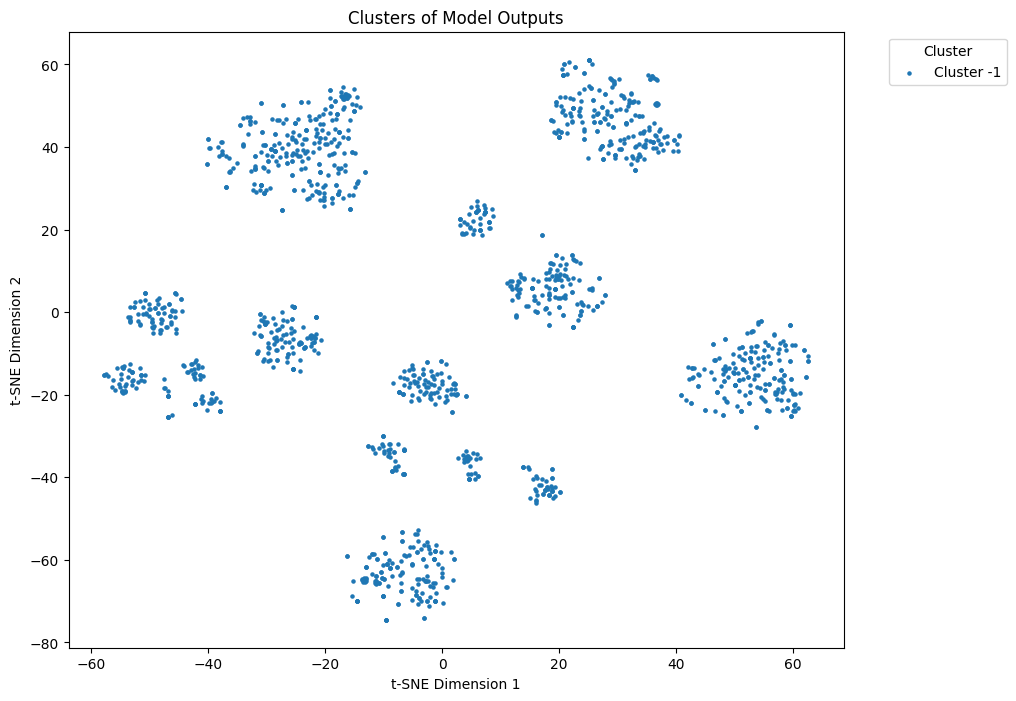

In [18]:
outputs_array = np.array(outputs)
outputs_array = outputs_array.reshape(outputs_array.shape[0], -1)  #flatten the last two dimensions

tsne = TSNE(n_components=2, random_state=111)
tsne_outputs = tsne.fit_transform(outputs_array)

dbscan = DBSCAN(eps=0.1, min_samples=10)  
cluster_labels = dbscan.fit_predict(tsne_outputs)

unique_clusters = np.unique(cluster_labels)

plt.figure(figsize=(10, 8))
for cluster in unique_clusters:
    cluster_indices = np.where(cluster_labels == cluster)
    plt.scatter(tsne_outputs[cluster_indices, 0], tsne_outputs[cluster_indices, 1], label=f'Cluster {cluster}', s=5)

plt.title('Clusters of Model Outputs')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Future Work Writeup**

A) Expanding on Language Model Prediction:

As evident in works such as the *reference/(arXiv article), the increasing use of language models for specificity classification should not be overlooked. In our research, we have sought to incorporate some of the mentioned techniques, specifically focusing on the BERT-based and Immune2Vec models (reference the papers for both). Currently, the implementations of both models are in preliminary stages, with minimal tuning and evaluation conducted using basic sklearn models. However, despite this initial stage, the observed accuracy scores for both models suggest that further workings would be beneficial, particularly considering the lack of training data after applying of our chosen filters compared to the size and success of the fully developed models.


**Bert Model**

*Start it somehow, The capabilities of the BERT (Bidirectional Encoder Representations from Transformers) language model has gained significant attention in the field. Unlike traditional language models, BERT is designed to consider the context from both the left and the right side of a token in all layers of the model. This bidirectional approach allows BERT to understand the context and the semantic meaning of a word in a sentence more accurately. With regards to our project, the TCR-Bert model has been trained to embed the cdr3 sequences which can then be used in downstream prediction tasks.

**Immune2Vec**

Alongside our exploration of BERT, we've also looked into using Immune2Vec, a model inspired by word2vec but designed specifically for immunological data. Immune2Vec treats immune receptors as "sentences" and amino acids as "words," allowing us to tap into the power of word embeddings. We trained the Immune2Vec model on the limited amount of cdr3 sequences available, generating a vector representation for each unique amino acid sequence which captures the semantic similarity between different sequences and outputs an embedding for the full sequence. These embeddings have shown to be useful at prediction with an accuracy score of 0.552 when used alongside a random forrest classifier. 



